In [9]:
class NavalWarfare_v2:
    def __init__(self,field_size=10):
        state = np.zeros((field_size+2,field_size+2))
        ships = [1] * 4 + [2] * 3 + [3] * 2 + [4]
        N = field_size
        self.actions = np.array(range(N**2))
        for ship in ships:
#             print(ship)
#             print(state.shape)
            isNotReady = True       
            while isNotReady:
                x = np.random.randint(1,field_size+1)
                y = np.random.randint(1,field_size+1)
                orientation = np.random.randint(2)
                isNotReady = False
                for i in range(ship):
                    if (state[x,y] != 1 
                    and state[x-1, y] != 1 and state[x+1, y] != 1
                    and state[x, y-1] != 1 and state[x, y+1] != 1
                    and state[x-1, y-1] != 1 and state[x+1, y+1] != 1
                    and state[x+1, y-1] != 1 and state[x-1, y+1] != 1
                    and x in range(1,field_size+1) and y in range(1,field_size+1)):
                        state[x,y] = -1
                        if orientation == 0:
                            x -= 1
                        else:
                            y -= 1
                    else:
                        isNotReady = True
                        state = np.maximum(state,0)
                        break
                state = np.abs(state)
            
            self.state = state[1:-1,1:-1]
            self.observable = np.zeros((N,N,2))# one for tested fields, one - for sunken ships
            self.N = N

            
    def set_state(self, state_matix):
        self.state = state_matix
        
    def move(self,action):
            x = action % self.N
            y = action // self.N
            x,y = y,x # test
#             print(x,y)
            end_game = False
            repeat_turn = False
            reward = 0
            if self.state[x,y] == 1:
                self.state[x,y] = -1
                self.observable[x,y,0] = 1
                self.observable[x,y,1] = 1
                if np.max(self.state) == 0:
                    end_game = True
                    reward = 10 # was 100
                else:
                    reward = 10 # 
                    repeat_turn = True
            elif self.state[x,y] == -1:
                self.state[x,y] = -1
                self.observable[x,y,0] = 1
                self.observable[x,y,1] = 1
            else:
                self.observable[x,y,0] = 1
            
            return reward, end_game, repeat_turn, self.observable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Maximum
from keras.layers import Conv2D,MaxPooling2D,Reshape,Flatten

In [3]:
from tqdm import tqdm
from keras.optimizers import Adam

In [4]:
# simple convolutional filter
def model_conv_2():
    model = Sequential()
    model.add(Reshape((10,10,2),input_shape=(1,200)))
    kern_shape = (5,5)
    model.add(Conv2D(filters=1,kernel_size =kern_shape,strides=(1,1), padding='same', activation='linear', input_shape=(10, 10, 2)))
    
    model.add(Flatten())
    opt = Adam(learning_rate=0.1)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    return model

In [5]:
def play_game(model, max_turns=100, print_info=True):
        turns = 0
        field = NavalWarfare_v2(10)
        end_game = False
        turns = 0
        state = np.zeros((10,10,2))
        while not end_game and turns < max_turns:
            turns += 1
    #             print(np.sum(field.state))
    #             print(np.sum(state))
            Q = model.predict(state.flatten().reshape(1,10,10,2))
            action = np.argmax(Q)
            reward,end_game,repeat,state = field.move(action)
        tested_fields = np.sum(state[:,:,0])
        sunken = np.sum(state[:,:,1])
        if print_info:
#             S = (np.sum(field.state) + 20 ) // 2
            print(f'turns : {turns}')
            print(f'sunken ships: {sunken}')
            print(f'ships left: {20 - sunken}')
            print(f'fields tested: {tested_fields}')
        return turns, sunken, tested_fields

In [6]:
test_turns = []
test_sunken = []
test_fields = []

train_turns = []
train_sunken = []
train_fields = []
episodes = []

eps0 = 0.5
eps_decay_factor = 0.98
num_episodes=100
start_epochs = 10
discount_factor = 0.99

model = model_conv_2()

In [7]:
for i in tqdm(range(num_episodes)):
    field = NavalWarfare_v2(10)
    N = field.N
    actions = field.actions
    state = field.observable
    if i < start_epochs:
        eps = 1
    elif i == start_epochs:
        print('pretraining finished')
        eps = eps0
    eps *= eps_decay_factor
    end_game = False
    turns = 0
    target_batch = []
    states_batch = []
    while not end_game and (turns < 100 or i < start_epochs):
        turns += 1
        if turns % 100 == 0:
#             S = (np.sum(field.state) + 20 ) // 2
#             sunken = 20 - S
#             tested_fields = np.sum(state < 0)
#             print(np.sum(field.state))
#             print(np.sum(state))
            tested_fields = np.sum(state[:,:,0])
            sunken = np.sum(state[:,:,1])
            print(f'train play results on episode {i}')
            print(f'sunken ships: {sunken}')
            print(f'ships left: {20 - sunken}')
            print(f'fields tested: {tested_fields}')
            print(f'-------------')
            
        Q = model.predict(state.flatten().reshape(1,-1))
        if np.random.random() < eps:
            action = np.random.choice(actions)
        else:
            action = np.argmax(
                Q
              )
        r,end_game,repeat,new_state = field.move(action)
        reward = r - 5
        Q_new = model.predict(new_state.flatten().reshape(1,-1))
        q = Q[0,action]
#         print(Q.shape,type(q),q.shape)
        target = (reward + 
          discount_factor * 
            (q - np.max(
              Q_new
                 )))
        target_vector = Q[0]
        target_vector[action] = target
        target_batch.append(target_vector.reshape(1,-1))
        states_batch.append(state.flatten().reshape(1,-1))
        state = new_state
        model.fit(state.flatten().reshape(1,1,-1),target_vector.reshape(1,1,-1),epochs=1, verbose=0)
#     states_batch = np.array(states_batch).reshape(turns,-1)
#     target_batch = np.array(target_batch).reshape(turns,-1)
#     print(states_batch.shape)
#     model.fit(
#           states_batch,  
#           target_batch, 
#           epochs=1, verbose=0)
    tested_fields = np.sum(state[:,:,0])
    sunken = np.sum(state[:,:,1])
    train_turns.append(turns)
    train_fields.append(tested_fields)
    train_sunken.append(sunken)
    if i % 10 == 0:
        print(f'test play results after episode {i}')
        turns, sunken, tested_fields = play_game(model)
        test_turns.append(turns)
        test_fields.append(tested_fields)
        test_sunken.append(sunken)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

train play results on episode 0
sunken ships: 15.0
ships left: 5.0
fields tested: 68.0
-------------
train play results on episode 0
sunken ships: 16.0
ships left: 4.0
fields tested: 84.0
-------------
train play results on episode 0
sunken ships: 19.0
ships left: 1.0
fields tested: 94.0
-------------
train play results on episode 0
sunken ships: 19.0
ships left: 1.0
fields tested: 97.0
-------------
test play results after episode 0


  1%|▊                                                                               | 1/100 [00:58<1:36:15, 58.34s/it]

turns : 100
sunken ships: 4.0
ships left: 16.0
fields tested: 22.0
train play results on episode 1
sunken ships: 15.0
ships left: 5.0
fields tested: 61.0
-------------
train play results on episode 1
sunken ships: 18.0
ships left: 2.0
fields tested: 88.0
-------------
train play results on episode 1
sunken ships: 19.0
ships left: 1.0
fields tested: 93.0
-------------


  2%|█▌                                                                              | 2/100 [01:47<1:30:40, 55.52s/it]

train play results on episode 2
sunken ships: 14.0
ships left: 6.0
fields tested: 63.0
-------------


  3%|██▍                                                                             | 3/100 [02:13<1:15:42, 46.83s/it]

train play results on episode 3
sunken ships: 16.0
ships left: 4.0
fields tested: 66.0
-------------


  4%|███▏                                                                            | 4/100 [02:38<1:04:08, 40.09s/it]

train play results on episode 4
sunken ships: 12.0
ships left: 8.0
fields tested: 58.0
-------------
train play results on episode 4
sunken ships: 19.0
ships left: 1.0
fields tested: 86.0
-------------


  5%|████                                                                              | 5/100 [03:03<56:37, 35.76s/it]

train play results on episode 5
sunken ships: 12.0
ships left: 8.0
fields tested: 58.0
-------------
train play results on episode 5
sunken ships: 15.0
ships left: 5.0
fields tested: 84.0
-------------
train play results on episode 5
sunken ships: 17.0
ships left: 3.0
fields tested: 96.0
-------------
train play results on episode 5
sunken ships: 19.0
ships left: 1.0
fields tested: 99.0
-------------


  6%|████▊                                                                           | 6/100 [03:55<1:03:20, 40.43s/it]

train play results on episode 6
sunken ships: 12.0
ships left: 8.0
fields tested: 60.0
-------------
train play results on episode 6
sunken ships: 18.0
ships left: 2.0
fields tested: 89.0
-------------


  7%|█████▋                                                                            | 7/100 [04:28<59:28, 38.37s/it]

train play results on episode 7
sunken ships: 15.0
ships left: 5.0
fields tested: 66.0
-------------
train play results on episode 7
sunken ships: 18.0
ships left: 2.0
fields tested: 90.0
-------------


  8%|██████▌                                                                           | 8/100 [05:03<57:01, 37.19s/it]

train play results on episode 8
sunken ships: 12.0
ships left: 8.0
fields tested: 64.0
-------------
train play results on episode 8
sunken ships: 18.0
ships left: 2.0
fields tested: 86.0
-------------


  9%|███████▍                                                                          | 9/100 [05:38<55:33, 36.63s/it]

train play results on episode 9
sunken ships: 12.0
ships left: 8.0
fields tested: 59.0
-------------
train play results on episode 9
sunken ships: 14.0
ships left: 6.0
fields tested: 83.0
-------------
train play results on episode 9
sunken ships: 19.0
ships left: 1.0
fields tested: 95.0
-------------


 10%|████████                                                                         | 10/100 [06:22<58:08, 38.76s/it]

pretraining finished
train play results on episode 10
sunken ships: 13.0
ships left: 7.0
fields tested: 78.0
-------------
test play results after episode 10


 11%|████████▉                                                                        | 11/100 [06:38<47:41, 32.15s/it]

turns : 100
sunken ships: 15.0
ships left: 5.0
fields tested: 72.0


 12%|█████████▋                                                                       | 12/100 [06:51<38:37, 26.33s/it]

train play results on episode 11
sunken ships: 13.0
ships left: 7.0
fields tested: 71.0
-------------


 13%|██████████▌                                                                      | 13/100 [07:04<32:15, 22.25s/it]

train play results on episode 12
sunken ships: 16.0
ships left: 4.0
fields tested: 78.0
-------------


 14%|███████████▎                                                                     | 14/100 [07:17<27:48, 19.40s/it]

train play results on episode 13
sunken ships: 14.0
ships left: 6.0
fields tested: 78.0
-------------


 15%|████████████▏                                                                    | 15/100 [07:30<24:42, 17.44s/it]

train play results on episode 14
sunken ships: 19.0
ships left: 1.0
fields tested: 79.0
-------------


 16%|████████████▉                                                                    | 16/100 [07:42<22:12, 15.87s/it]

train play results on episode 15
sunken ships: 18.0
ships left: 2.0
fields tested: 82.0
-------------


 17%|█████████████▊                                                                   | 17/100 [07:54<20:26, 14.78s/it]

train play results on episode 16
sunken ships: 17.0
ships left: 3.0
fields tested: 77.0
-------------


 18%|██████████████▌                                                                  | 18/100 [08:06<19:04, 13.96s/it]

train play results on episode 17
sunken ships: 18.0
ships left: 2.0
fields tested: 82.0
-------------


 19%|███████████████▍                                                                 | 19/100 [08:19<18:23, 13.62s/it]

train play results on episode 18
sunken ships: 17.0
ships left: 3.0
fields tested: 83.0
-------------


 20%|████████████████▏                                                                | 20/100 [08:31<17:42, 13.28s/it]

train play results on episode 19
sunken ships: 18.0
ships left: 2.0
fields tested: 85.0
-------------
train play results on episode 20
sunken ships: 16.0
ships left: 4.0
fields tested: 78.0
-------------
test play results after episode 20


 21%|█████████████████                                                                | 21/100 [08:48<18:45, 14.25s/it]

turns : 100
sunken ships: 17.0
ships left: 3.0
fields tested: 89.0


 23%|██████████████████▋                                                              | 23/100 [09:12<17:02, 13.28s/it]

train play results on episode 22
sunken ships: 18.0
ships left: 2.0
fields tested: 84.0
-------------


 24%|███████████████████▍                                                             | 24/100 [09:25<16:35, 13.10s/it]

train play results on episode 23
sunken ships: 17.0
ships left: 3.0
fields tested: 80.0
-------------


 25%|████████████████████▎                                                            | 25/100 [09:37<16:06, 12.89s/it]

train play results on episode 24
sunken ships: 15.0
ships left: 5.0
fields tested: 81.0
-------------


 26%|█████████████████████                                                            | 26/100 [09:50<15:36, 12.66s/it]

train play results on episode 25
sunken ships: 18.0
ships left: 2.0
fields tested: 82.0
-------------


 27%|█████████████████████▊                                                           | 27/100 [10:02<15:14, 12.53s/it]

train play results on episode 26
sunken ships: 18.0
ships left: 2.0
fields tested: 83.0
-------------


 28%|██████████████████████▋                                                          | 28/100 [10:14<15:04, 12.56s/it]

train play results on episode 27
sunken ships: 18.0
ships left: 2.0
fields tested: 87.0
-------------


 30%|████████████████████████▎                                                        | 30/100 [10:39<14:32, 12.46s/it]

train play results on episode 29
sunken ships: 17.0
ships left: 3.0
fields tested: 77.0
-------------
train play results on episode 30
sunken ships: 17.0
ships left: 3.0
fields tested: 87.0
-------------
test play results after episode 30


 31%|█████████████████████████                                                        | 31/100 [10:55<15:41, 13.64s/it]

turns : 98
sunken ships: 20.0
ships left: 0.0
fields tested: 98.0


 32%|█████████████████████████▉                                                       | 32/100 [11:08<15:10, 13.39s/it]

train play results on episode 31
sunken ships: 18.0
ships left: 2.0
fields tested: 88.0
-------------


 33%|██████████████████████████▋                                                      | 33/100 [11:21<14:36, 13.08s/it]

train play results on episode 32
sunken ships: 16.0
ships left: 4.0
fields tested: 83.0
-------------


 34%|███████████████████████████▌                                                     | 34/100 [11:33<14:14, 12.94s/it]

train play results on episode 33
sunken ships: 19.0
ships left: 1.0
fields tested: 86.0
-------------


 35%|████████████████████████████▎                                                    | 35/100 [11:46<13:58, 12.90s/it]

train play results on episode 34
sunken ships: 19.0
ships left: 1.0
fields tested: 86.0
-------------


 36%|█████████████████████████████▏                                                   | 36/100 [11:59<13:46, 12.92s/it]

train play results on episode 35
sunken ships: 18.0
ships left: 2.0
fields tested: 89.0
-------------


 37%|█████████████████████████████▉                                                   | 37/100 [12:12<13:30, 12.86s/it]

train play results on episode 36
sunken ships: 19.0
ships left: 1.0
fields tested: 88.0
-------------


 38%|██████████████████████████████▊                                                  | 38/100 [12:24<13:11, 12.76s/it]

train play results on episode 37
sunken ships: 18.0
ships left: 2.0
fields tested: 86.0
-------------


 39%|███████████████████████████████▌                                                 | 39/100 [12:38<13:11, 12.97s/it]

train play results on episode 38
sunken ships: 17.0
ships left: 3.0
fields tested: 87.0
-------------


 40%|████████████████████████████████▍                                                | 40/100 [12:51<13:08, 13.13s/it]

train play results on episode 40
sunken ships: 18.0
ships left: 2.0
fields tested: 86.0
-------------
test play results after episode 40


 41%|█████████████████████████████████▏                                               | 41/100 [13:08<14:00, 14.25s/it]

turns : 95
sunken ships: 20.0
ships left: 0.0
fields tested: 95.0


 42%|██████████████████████████████████                                               | 42/100 [13:21<13:16, 13.73s/it]

train play results on episode 41
sunken ships: 18.0
ships left: 2.0
fields tested: 86.0
-------------
train play results on episode 42
sunken ships: 18.0
ships left: 2.0
fields tested: 88.0
-------------


 44%|███████████████████████████████████▋                                             | 44/100 [13:46<12:21, 13.24s/it]

train play results on episode 43
sunken ships: 18.0
ships left: 2.0
fields tested: 91.0
-------------


 45%|████████████████████████████████████▍                                            | 45/100 [14:00<12:25, 13.56s/it]

train play results on episode 44
sunken ships: 17.0
ships left: 3.0
fields tested: 84.0
-------------


 46%|█████████████████████████████████████▎                                           | 46/100 [14:14<12:15, 13.63s/it]

train play results on episode 45
sunken ships: 18.0
ships left: 2.0
fields tested: 88.0
-------------


 47%|██████████████████████████████████████                                           | 47/100 [14:28<12:00, 13.60s/it]

train play results on episode 46
sunken ships: 18.0
ships left: 2.0
fields tested: 90.0
-------------


 48%|██████████████████████████████████████▉                                          | 48/100 [14:40<11:32, 13.32s/it]

train play results on episode 47
sunken ships: 18.0
ships left: 2.0
fields tested: 87.0
-------------


 49%|███████████████████████████████████████▋                                         | 49/100 [14:53<11:16, 13.27s/it]

train play results on episode 48
sunken ships: 19.0
ships left: 1.0
fields tested: 93.0
-------------


 50%|████████████████████████████████████████▌                                        | 50/100 [15:07<11:07, 13.35s/it]

train play results on episode 49
sunken ships: 19.0
ships left: 1.0
fields tested: 92.0
-------------
test play results after episode 50


 51%|█████████████████████████████████████████▎                                       | 51/100 [15:24<11:52, 14.54s/it]

turns : 99
sunken ships: 20.0
ships left: 0.0
fields tested: 99.0


 52%|██████████████████████████████████████████                                       | 52/100 [15:38<11:22, 14.22s/it]

train play results on episode 51
sunken ships: 18.0
ships left: 2.0
fields tested: 90.0
-------------


 54%|███████████████████████████████████████████▋                                     | 54/100 [16:04<10:27, 13.64s/it]

train play results on episode 53
sunken ships: 18.0
ships left: 2.0
fields tested: 93.0
-------------


 55%|████████████████████████████████████████████▌                                    | 55/100 [16:17<10:08, 13.52s/it]

train play results on episode 54
sunken ships: 14.0
ships left: 6.0
fields tested: 84.0
-------------


 56%|█████████████████████████████████████████████▎                                   | 56/100 [16:31<09:57, 13.58s/it]

train play results on episode 55
sunken ships: 19.0
ships left: 1.0
fields tested: 89.0
-------------


 57%|██████████████████████████████████████████████▏                                  | 57/100 [16:45<09:47, 13.65s/it]

train play results on episode 56
sunken ships: 18.0
ships left: 2.0
fields tested: 92.0
-------------


 58%|██████████████████████████████████████████████▉                                  | 58/100 [16:58<09:25, 13.45s/it]

train play results on episode 57
sunken ships: 17.0
ships left: 3.0
fields tested: 89.0
-------------


 59%|███████████████████████████████████████████████▊                                 | 59/100 [17:11<09:05, 13.32s/it]

train play results on episode 58
sunken ships: 16.0
ships left: 4.0
fields tested: 92.0
-------------


 60%|████████████████████████████████████████████████▌                                | 60/100 [17:24<08:57, 13.45s/it]

train play results on episode 59
sunken ships: 19.0
ships left: 1.0
fields tested: 96.0
-------------
train play results on episode 60
sunken ships: 19.0
ships left: 1.0
fields tested: 92.0
-------------
test play results after episode 60


 61%|█████████████████████████████████████████████████▍                               | 61/100 [17:42<09:37, 14.80s/it]

turns : 99
sunken ships: 20.0
ships left: 0.0
fields tested: 99.0


 62%|██████████████████████████████████████████████████▏                              | 62/100 [17:56<09:04, 14.32s/it]

train play results on episode 61
sunken ships: 18.0
ships left: 2.0
fields tested: 91.0
-------------


 63%|███████████████████████████████████████████████████                              | 63/100 [18:09<08:40, 14.08s/it]

train play results on episode 62
sunken ships: 19.0
ships left: 1.0
fields tested: 91.0
-------------


 64%|███████████████████████████████████████████████████▊                             | 64/100 [18:22<08:16, 13.79s/it]

train play results on episode 63
sunken ships: 19.0
ships left: 1.0
fields tested: 92.0
-------------
train play results on episode 64
sunken ships: 19.0
ships left: 1.0
fields tested: 92.0
-------------


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [18:48<07:31, 13.28s/it]

train play results on episode 65
sunken ships: 19.0
ships left: 1.0
fields tested: 94.0
-------------


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [19:01<07:19, 13.32s/it]

train play results on episode 66
sunken ships: 18.0
ships left: 2.0
fields tested: 92.0
-------------


 68%|███████████████████████████████████████████████████████                          | 68/100 [19:14<07:00, 13.13s/it]

train play results on episode 67
sunken ships: 19.0
ships left: 1.0
fields tested: 92.0
-------------


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [19:27<06:48, 13.16s/it]

train play results on episode 68
sunken ships: 17.0
ships left: 3.0
fields tested: 94.0
-------------


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [19:39<06:26, 12.88s/it]

train play results on episode 70
sunken ships: 17.0
ships left: 3.0
fields tested: 96.0
-------------
test play results after episode 70


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [19:56<06:50, 14.15s/it]

turns : 96
sunken ships: 20.0
ships left: 0.0
fields tested: 96.0


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [20:10<06:29, 13.91s/it]

train play results on episode 71
sunken ships: 19.0
ships left: 1.0
fields tested: 89.0
-------------


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [20:23<06:08, 13.64s/it]

train play results on episode 72
sunken ships: 19.0
ships left: 1.0
fields tested: 96.0
-------------


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [20:48<05:27, 13.11s/it]

train play results on episode 74
sunken ships: 16.0
ships left: 4.0
fields tested: 90.0
-------------


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [21:01<05:13, 13.08s/it]

train play results on episode 75
sunken ships: 19.0
ships left: 1.0
fields tested: 92.0
-------------


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [21:14<04:59, 13.00s/it]

train play results on episode 76
sunken ships: 18.0
ships left: 2.0
fields tested: 91.0
-------------


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [21:26<04:41, 12.77s/it]

train play results on episode 77
sunken ships: 19.0
ships left: 1.0
fields tested: 93.0
-------------


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [21:38<04:25, 12.66s/it]

train play results on episode 78
sunken ships: 18.0
ships left: 2.0
fields tested: 92.0
-------------


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [21:51<04:15, 12.76s/it]

train play results on episode 79
sunken ships: 18.0
ships left: 2.0
fields tested: 92.0
-------------
train play results on episode 80
sunken ships: 18.0
ships left: 2.0
fields tested: 89.0
-------------
test play results after episode 80


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [22:09<04:28, 14.13s/it]

turns : 96
sunken ships: 20.0
ships left: 0.0
fields tested: 96.0


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [22:35<03:51, 13.63s/it]

train play results on episode 82
sunken ships: 19.0
ships left: 1.0
fields tested: 94.0
-------------


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [23:02<03:22, 13.53s/it]

train play results on episode 84
sunken ships: 19.0
ships left: 1.0
fields tested: 95.0
-------------


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [23:15<03:06, 13.36s/it]

train play results on episode 85
sunken ships: 18.0
ships left: 2.0
fields tested: 94.0
-------------


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [23:41<02:38, 13.17s/it]

train play results on episode 87
sunken ships: 17.0
ships left: 3.0
fields tested: 91.0
-------------


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [23:53<02:23, 13.08s/it]

train play results on episode 88
sunken ships: 16.0
ships left: 4.0
fields tested: 92.0
-------------


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [24:07<02:10, 13.07s/it]

train play results on episode 90
sunken ships: 19.0
ships left: 1.0
fields tested: 93.0
-------------
test play results after episode 90


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [24:23<02:06, 14.10s/it]

turns : 96
sunken ships: 20.0
ships left: 0.0
fields tested: 96.0


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [24:36<01:49, 13.68s/it]

train play results on episode 91
sunken ships: 19.0
ships left: 1.0
fields tested: 91.0
-------------


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [24:49<01:34, 13.52s/it]

train play results on episode 92
sunken ships: 18.0
ships left: 2.0
fields tested: 95.0
-------------


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [25:02<01:20, 13.47s/it]

train play results on episode 93
sunken ships: 17.0
ships left: 3.0
fields tested: 87.0
-------------


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [25:27<00:52, 13.06s/it]

train play results on episode 95
sunken ships: 19.0
ships left: 1.0
fields tested: 99.0
-------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [26:19<00:00, 15.79s/it]

train play results on episode 99
sunken ships: 19.0
ships left: 1.0
fields tested: 98.0
-------------


In [8]:
i

99

In [9]:
turns

100

learning curves

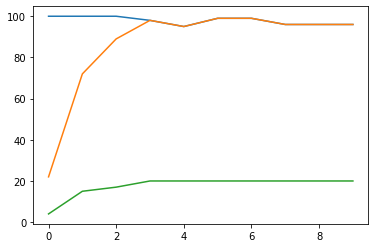

In [22]:
plt.plot(test_turns)
plt.plot(test_fields)
plt.plot(test_sunken)
plt.show()

parameters interpretation

In [30]:
weights = model.weights[0].numpy()

In [31]:
weights.shape

(5, 5, 2, 1)

tested fields filter

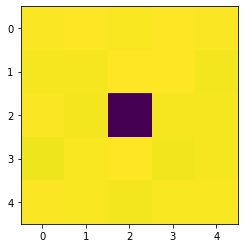

In [37]:
plt.imshow(weights[:,:,0,0])

 suken ships filter

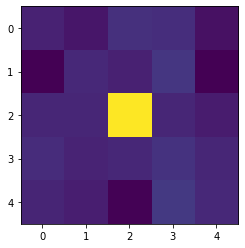

In [35]:
plt.imshow(weights[:,:,1,0])

In [43]:
test_turns = []
test_sunken = []
test_fields = []
turns, sunken, tested_fields = 0,0,0
for i in tqdm(range(20)):
    turns, sunken, tested_fields = play_game(model, print_info=False)
    test_turns.append(turns)
    test_fields.append(tested_fields)
    test_sunken.append(sunken)
print(np.mean(test_turns))
print(np.mean(test_sunken))
print(np.mean(test_fields))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/it]

97.75
20.0
97.75


In [48]:
w0 = model.weights[0].numpy()
w1 = model.weights[1].numpy()

In [53]:
print(w0,w1)

[[[[ 3.18499625e-01]
   [-2.66354624e-02]]

  [[ 4.80377853e-01]
   [-4.26989824e-01]]

  [[ 1.55931011e-01]
   [ 4.58815634e-01]]

  [[ 4.37124670e-01]
   [ 3.52269500e-01]]

  [[ 2.28693634e-01]
   [-6.30790293e-01]]]


 [[[ 4.54395451e-03]
   [-1.12376845e+00]]

  [[-1.21115886e-01]
   [ 1.74029812e-01]]

  [[ 5.42712986e-01]
   [-6.38341159e-02]]

  [[ 4.01279688e-01]
   [ 6.86757982e-01]]

  [[-2.60712057e-01]
   [-1.11941016e+00]]]


 [[[ 3.18737119e-01]
   [ 9.11089927e-02]]

  [[-2.14447424e-01]
   [ 8.19894522e-02]]

  [[-4.43702393e+01]
   [ 1.03068752e+01]]

  [[-6.95348606e-02]
   [ 8.58713165e-02]]

  [[-6.08133897e-02]
   [-2.46061146e-01]]]


 [[[-5.65936089e-01]
   [ 3.14782470e-01]]

  [[ 1.26882300e-01]
   [ 3.70053574e-02]]

  [[ 5.54339230e-01]
   [ 1.47755325e-01]]

  [[-3.31431597e-01]
   [ 5.52995443e-01]]

  [[-9.40761343e-02]
   [ 9.69765633e-02]]]


 [[[ 3.40548038e-01]
   [ 6.96009845e-02]]

  [[ 6.46156892e-02]
   [-1.72884747e-01]]

  [[-2.32868031e-01]
   

more complicated network architecture 

In [10]:
def model_conv_2_():
    model = Sequential()
    model.add(Reshape((10,10,2),input_shape=(1,200)))
    kern_shape = (5,5)
    model.add(Conv2D(filters=4,kernel_size =kern_shape,strides=(1,1), padding='same', activation='relu', input_shape=(10, 10, 2),use_bias=False))
    model.add(Conv2D(filters=1,kernel_size =(4,4),strides=(1,1), padding='same', activation='linear', input_shape=(10, 10, 4),use_bias=False))
#     model.add(Conv2D(filters=1,kernel_size =(2,2),strides=(1,1), padding='same', activation='linear', input_shape=(10, 10, 4),use_bias=False))
    model.add(Flatten())
    opt = Adam(learning_rate=0.05)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    return model

In [11]:
test_turns = []
test_sunken = []
test_fields = []

train_turns = []
train_sunken = []
train_fields = []
episodes = []

eps0 = 0.25
eps_decay_factor = 0.99
num_episodes= 150
start_epochs = 0
discount_factor = 0.9 # was 0.99

model = model_conv_2_()

In [12]:
for i in tqdm(range(num_episodes)):
    field = NavalWarfare_v2(10)
    N = field.N
    actions = field.actions
    state = field.observable
    if i < start_epochs:
        eps = 1
    elif i == start_epochs:
        print('pretraining finished')
        eps = eps0
    eps *= eps_decay_factor
    end_game = False
    turns = 0
    target_batch = []
    states_batch = []
    while not end_game and (turns < 100 or i < start_epochs):
        turns += 1
        if turns % 100 == 0:
#             S = (np.sum(field.state) + 20 ) // 2
#             sunken = 20 - S
#             tested_fields = np.sum(state < 0)
#             print(np.sum(field.state))
#             print(np.sum(state))
            tested_fields = np.sum(state[:,:,0])
            sunken = np.sum(state[:,:,1])
            print(f'train play results on episode {i}')
            print(f'epsilon {eps}')
            print(f'sunken ships: {sunken}')
            print(f'ships left: {20 - sunken}')
            print(f'fields tested: {tested_fields}')
            print(f'-------------')
            
        Q = model.predict(state.flatten().reshape(1,-1))
        if np.random.random() < eps:
            action = np.random.choice(actions)
        else:
            action = np.argmax(
                Q
              )
        r,end_game,repeat,new_state = field.move(action)
        reward = r - 5
        Q_new = model.predict(new_state.flatten().reshape(1,-1))
        q = Q[0,action]
#         print(Q.shape,type(q),q.shape)
        target = (reward + 
          discount_factor * 
            (q - np.max(
              Q_new
                 )))
        target_vector = Q[0]
        target_vector[action] = target
        target_batch.append(target_vector.reshape(1,-1))
        states_batch.append(state.flatten().reshape(1,-1))
        state = new_state
        model.fit(state.flatten().reshape(1,1,-1),target_vector.reshape(1,1,-1),epochs=1, verbose=0)
#     states_batch = np.array(states_batch).reshape(turns,-1)
#     target_batch = np.array(target_batch).reshape(turns,-1)
#     print(states_batch.shape)
#     model.fit(
#           states_batch,  
#           target_batch, 
#           epochs=1, verbose=0)
    tested_fields = np.sum(state[:,:,0])
    sunken = np.sum(state[:,:,1])
    train_turns.append(turns)
    train_fields.append(tested_fields)
    train_sunken.append(sunken)
    if i % 10 == 0:
        print(f'test play results after episode {i}')
        turns, sunken, tested_fields = play_game(model)
        test_turns.append(turns)
        test_fields.append(tested_fields)
        test_sunken.append(sunken)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

pretraining finished
train play results on episode 0
epsilon 0.2475
sunken ships: 12.0
ships left: 8.0
fields tested: 62.0
-------------
test play results after episode 0


  1%|▌                                                                                 | 1/150 [00:17<42:42, 17.20s/it]

turns : 100
sunken ships: 6.0
ships left: 14.0
fields tested: 15.0


  1%|█                                                                                 | 2/150 [00:29<38:56, 15.79s/it]

train play results on episode 1
epsilon 0.245025
sunken ships: 13.0
ships left: 7.0
fields tested: 62.0
-------------


  2%|█▋                                                                                | 3/150 [00:42<36:19, 14.82s/it]

train play results on episode 2
epsilon 0.24257474999999998
sunken ships: 14.0
ships left: 6.0
fields tested: 67.0
-------------


  3%|██▏                                                                               | 4/150 [00:54<34:32, 14.20s/it]

train play results on episode 3
epsilon 0.2401490025
sunken ships: 14.0
ships left: 6.0
fields tested: 64.0
-------------


  3%|██▋                                                                               | 5/150 [01:07<33:26, 13.84s/it]

train play results on episode 4
epsilon 0.23774751247499998
sunken ships: 16.0
ships left: 4.0
fields tested: 59.0
-------------


  4%|███▎                                                                              | 6/150 [01:20<32:30, 13.54s/it]

train play results on episode 5
epsilon 0.23537003735024997
sunken ships: 13.0
ships left: 7.0
fields tested: 67.0
-------------


  5%|███▊                                                                              | 7/150 [01:33<31:29, 13.21s/it]

train play results on episode 6
epsilon 0.23301633697674748
sunken ships: 6.0
ships left: 14.0
fields tested: 51.0
-------------


  5%|████▎                                                                             | 8/150 [01:45<30:51, 13.04s/it]

train play results on episode 7
epsilon 0.23068617360698
sunken ships: 12.0
ships left: 8.0
fields tested: 60.0
-------------


  6%|████▉                                                                             | 9/150 [01:58<30:17, 12.89s/it]

train play results on episode 8
epsilon 0.22837931187091018
sunken ships: 11.0
ships left: 9.0
fields tested: 56.0
-------------


  7%|█████▍                                                                           | 10/150 [02:11<29:54, 12.82s/it]

train play results on episode 9
epsilon 0.22609551875220107
sunken ships: 10.0
ships left: 10.0
fields tested: 39.0
-------------
train play results on episode 10
epsilon 0.22383456356467907
sunken ships: 12.0
ships left: 8.0
fields tested: 57.0
-------------
test play results after episode 10


  7%|█████▉                                                                           | 11/150 [02:27<32:21, 13.97s/it]

turns : 100
sunken ships: 1.0
ships left: 19.0
fields tested: 2.0


  8%|██████▍                                                                          | 12/150 [02:40<31:17, 13.61s/it]

train play results on episode 11
epsilon 0.22159621792903228
sunken ships: 12.0
ships left: 8.0
fields tested: 59.0
-------------


  9%|███████                                                                          | 13/150 [02:53<30:29, 13.35s/it]

train play results on episode 12
epsilon 0.21938025574974196
sunken ships: 10.0
ships left: 10.0
fields tested: 59.0
-------------


  9%|███████▌                                                                         | 14/150 [03:05<29:41, 13.10s/it]

train play results on episode 13
epsilon 0.21718645319224453
sunken ships: 10.0
ships left: 10.0
fields tested: 51.0
-------------


 10%|████████                                                                         | 15/150 [03:18<29:06, 12.94s/it]

train play results on episode 14
epsilon 0.21501458866032208
sunken ships: 14.0
ships left: 6.0
fields tested: 55.0
-------------
train play results on episode 15
epsilon 0.21286444277371885
sunken ships: 11.0
ships left: 9.0
fields tested: 44.0
-------------


 11%|█████████▏                                                                       | 17/150 [03:45<29:02, 13.10s/it]

train play results on episode 16
epsilon 0.21073579834598166
sunken ships: 12.0
ships left: 8.0
fields tested: 46.0
-------------


 12%|█████████▋                                                                       | 18/150 [03:58<29:00, 13.18s/it]

train play results on episode 17
epsilon 0.20862844036252184
sunken ships: 13.0
ships left: 7.0
fields tested: 57.0
-------------


 13%|██████████▎                                                                      | 19/150 [04:11<28:31, 13.07s/it]

train play results on episode 18
epsilon 0.20654215595889663
sunken ships: 10.0
ships left: 10.0
fields tested: 47.0
-------------


 13%|██████████▊                                                                      | 20/150 [04:24<28:07, 12.98s/it]

train play results on episode 19
epsilon 0.20447673439930766
sunken ships: 11.0
ships left: 9.0
fields tested: 57.0
-------------
train play results on episode 20
epsilon 0.20243196705531458
sunken ships: 12.0
ships left: 8.0
fields tested: 62.0
-------------
test play results after episode 20


 14%|███████████▎                                                                     | 21/150 [04:40<30:23, 14.14s/it]

turns : 100
sunken ships: 5.0
ships left: 15.0
fields tested: 17.0


 15%|███████████▉                                                                     | 22/150 [04:53<29:12, 13.70s/it]

train play results on episode 21
epsilon 0.20040764738476144
sunken ships: 12.0
ships left: 8.0
fields tested: 55.0
-------------


 15%|████████████▍                                                                    | 23/150 [05:06<28:21, 13.40s/it]

train play results on episode 22
epsilon 0.19840357091091382
sunken ships: 10.0
ships left: 10.0
fields tested: 47.0
-------------


 16%|████████████▉                                                                    | 24/150 [05:18<27:33, 13.12s/it]

train play results on episode 23
epsilon 0.1964195352018047
sunken ships: 15.0
ships left: 5.0
fields tested: 63.0
-------------


 17%|█████████████▌                                                                   | 25/150 [05:31<27:00, 12.97s/it]

train play results on episode 24
epsilon 0.19445533984978663
sunken ships: 5.0
ships left: 15.0
fields tested: 45.0
-------------


 17%|██████████████                                                                   | 26/150 [05:43<26:32, 12.84s/it]

train play results on episode 25
epsilon 0.19251078645128877
sunken ships: 11.0
ships left: 9.0
fields tested: 58.0
-------------


Exception ignored in: <generator object tqdm.__iter__ at 0x000001E111D03B30>
Traceback (most recent call last):
  File "C:\Users\Serg\anaconda3\lib\site-packages\tqdm\std.py", line 1182, in __iter__
    self.close()
  File "C:\Users\Serg\anaconda3\lib\site-packages\tqdm\std.py", line 1270, in close
    self._decr_instances(self)
  File "C:\Users\Serg\anaconda3\lib\site-packages\tqdm\std.py", line 572, in _decr_instances
    cls.monitor.exit()
  File "C:\Users\Serg\anaconda3\lib\site-packages\tqdm\_monitor.py", line 53, in exit
    self.join()
  File "C:\Users\Serg\anaconda3\lib\threading.py", line 1011, in join
    self._wait_for_tstate_lock()
  File "C:\Users\Serg\anaconda3\lib\threading.py", line 1027, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [92]:
weights = model.weights[0]

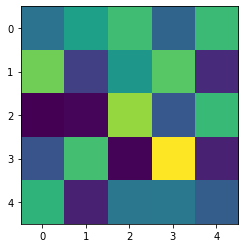

In [93]:
plt.imshow(weights[:,:,0,1])

In [65]:
weights[:,:,0,1]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[-0.26060268,  0.03132842, -0.26821512, -0.560089  ,  0.40299687],
       [-0.30829173, -0.2801677 , -0.614011  , -0.04526449, -0.31538263],
       [ 0.02985445, -0.20558262, -0.46046975, -0.6654351 , -0.28443277],
       [-0.02464282, -0.7611717 , -0.40779483,  0.22664683, -0.12330326],
       [-0.4942198 , -0.11929625, -0.27925485, -0.11105519, -0.4841313 ]],
      dtype=float32)>

In [88]:
test_turns = []
test_sunken = []
test_fields = []
turns, sunken, tested_fields = 0,0,0
for i in tqdm(range(20)):
    turns, sunken, tested_fields = play_game(model, print_info=False)
    test_turns.append(turns)
    test_fields.append(tested_fields)
    test_sunken.append(sunken)
print(np.mean(test_turns))
print(np.mean(test_sunken))
print(np.mean(test_fields))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]

100.0
0.75
3.6
